In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../context-mediation")
sys.path.append("../../relations")

from relations import estimate
from util import model_utils

import baukit
import torch

In [3]:
import transformers

# device = "cuda:0"
# config = "EleutherAI/gpt-j-6B"

# model = transformers.AutoModelForCausalLM.from_pretrained(config, revision="float16", low_cpu_mem_usage=False)
# model.to(device)

# tokenizer = transformers.AutoTokenizer.from_pretrained(config)
# tokenizer.pad_token = tokenizer.eos_token

MODEL_NAME = "EleutherAI/gpt-j-6B" # options gpt2-{} | "EleutherAI/gpt-neox-20b" | "EleutherAI/gpt-j-6B"
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [8]:
@torch.no_grad()
def estimate_relation_operator_fast(
    model,
    tokenizer,
    subject,
    relation,
    subject_token_index=-1,
    layer=25,
    device=None,
    module_name_format = "transformer.h.{}"
):
    model.to(device)

    prompt = relation.format(subject)
    inputs = tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True).to(
        device
    )

    offset_mapping = inputs.pop("offset_mapping")
    subject_i, subject_j = estimate.find_token_range(
        prompt, subject, offset_mapping=offset_mapping[0]
    )
    h_token_index = estimate.determine_token_index(
        subject_i,
        subject_j,
        subject_token_index,
    )

    # Precompute everything up to the subject.
    past_key_values = None
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    if subject_i > 0:
        outputs = model(
            input_ids=input_ids[:, :subject_i],
#             attention_mask=attention_mask[:, :subject_i],
            use_cache=True)
        past_key_values = outputs.past_key_values
        input_ids = input_ids[:, subject_i:]
        attention_mask = attention_mask[:, subject_i:]
        h_token_index -= subject_i

    # Precompute initial h and z.
    h_layer_name = module_name_format.format(layer)
    n_layer = "num_hidden_layers" if hasattr(model.config, "num_hidden_layers") else "n_layer"
    z_layer_name = module_name_format.format(getattr(model.config, n_layer) - 1)

    with baukit.TraceDict(model, (h_layer_name, z_layer_name)) as ret:
        model(input_ids=input_ids,
#               attention_mask=attention_mask,
              use_cache=past_key_values is not None,
              past_key_values=past_key_values)
    h = ret[h_layer_name].output[0][0, h_token_index]
    z = ret[z_layer_name].output[0][0, -1]

    # Now estimate J and b.
    def compute_z_from_h(h: torch.Tensor) -> torch.Tensor:
        def insert_h(output: tuple, layer: str) -> tuple:
            if layer != h_layer_name:
                return output
            output[0][0, h_token_index] = h
            return output

        with baukit.TraceDict(
            model, (h_layer_name, z_layer_name), edit_output=insert_h
        ) as ret:
            model(input_ids=input_ids,
#                   attention_mask=attention_mask,
                  past_key_values=past_key_values,
                  use_cache=past_key_values is not None)
        return ret[z_layer_name].output[0][0, -1]

    weight = torch.autograd.functional.jacobian(compute_z_from_h, h, vectorize=True)
    bias = z[None] - h[None].mm(weight.t())
    return estimate.RelationOperator(
        model=model,
        tokenizer=tokenizer,
        layer=layer,
        relation="{}" + relation.split("{}")[1],
        weight=weight,
        bias=bias,
    )

In [9]:
device = model.device

In [10]:
layer = 15
r = estimate_relation_operator_fast(
    model,
    tokenizer,
    "The Space Needle",
    "{} is located in the country of",
    layer=layer,
    device=model.device,
)
print(r("The Great Wall", subject_token_index=-1, device=model.device))

[' China', ' Seattle', ' Beijing', ' Taiwan', ' Japan']


In [12]:
from relations import estimate

import torch

# prompt = """\
# The Space Needle is located in Seattle.
# The Eiffel Tower is located in Paris.
# {} is located in"""
# subject = "The Great Wall"
# test_subjects = (
#     "The Eiffel Tower",
#     "Niagara Falls",
#     "The Empire State Building",
# )

# prompt = """\
# Bananas: yellow.
# Apples: red.
# {}:"""
# subject = "Kiwis"
# test_subjects = (
#     "Broccoli",
#     "Apples",
#     "Carrots",
#     "Potatoes",
#     "Cotton candy",
#     "Figs",
#     "Plums",
# )

# prompt = """\
# {} typically work inside of a"""
# Judges typically work inside of a courtroom.
# Nurses typically work inside of a hospital.
# test_subjects = (
#     "Farmers",
#     "Car mechanics",
#     "Teachers",
#     "Scientists",
# )
# subject = "Car mechanics"

prompt = """\
Megan Rapinoe plays the sport of soccer.
Larry Bird plays the sport of basketball.
John McEnroe plays the sport of tennis.
{} plays the sport of"""
subject = "Oksana Baiul"
test_subjects = (
    "Shaquille O'Neal",
    "Babe Ruth",
    "Tom Brady",
    "Tiger Woods",
    "Lionel Messi",
    "Michael Phelps",
    "Serena Williams",
)

# prompt = """\
# The meat of a banana is colored white.
# The meat of a strawberry is colored red.
# The meat of a {} is colored"""

# r = "have skin of the color"
# r = "have meat of the color"
# prompt = f"""\
# Banana {r} yellow.
# Potatoes {r} brown.
# """ + "{} " + r
# subject = "Blueberries"
# test_subjects = (
#     "Apples",
#     "Coconuts",
#     "Kiwis",
#     "Blueberries",
# )

# prompt = """\
# Bigger is the opposite of smaller.
# Empty is the opposite of full.
# {} is the opposite of"""
# subject = "Awake"
# test_subjects = (
#     "Dark",
#     "Alive",
#     "Bright",
#     "Smaller",
#     "Empty",
# )

# layer = 15

print(prompt, "\n")
print("training subject:", subject, "\n")

print("-- generations --")
for subj in (subject, *test_subjects):
    inputs = tokenizer(prompt.format(subj), return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=3, pad_token_id=tokenizer.eos_token_id)
    print(subj, tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:]))
print()
    
r_icl = estimate_relation_operator_fast(
    model,
    tokenizer,
    subject,
    prompt,
    layer=layer,
    device=device,
)
# r_icl.weight[:] = torch.eye(model.config.hidden_size).to(device)
# r_icl.bias[:] = 0
print("-- J/b predictions --")
for entity in test_subjects:
    print(entity, r_icl(entity, device=device))

Megan Rapinoe plays the sport of soccer.
Larry Bird plays the sport of basketball.
John McEnroe plays the sport of tennis.
{} plays the sport of 

training subject: Oksana Baiul 

-- generations --
Oksana Baiul [' figure skating.']
Shaquille O'Neal [' basketball.\n']
Babe Ruth [' baseball.\n']
Tom Brady [' football.\n']
Tiger Woods [' golf.\n']
Lionel Messi [' football.\n']
Michael Phelps [' swimming.\n']
Serena Williams [' tennis.\n']

-- J/b predictions --
Shaquille O'Neal [' ice', ' figure', ' basketball', ' wrestling', ' body']
Babe Ruth [' cur', ' golf', ' figure', ' ice', ' rac']
Tom Brady [' ice', ' figure', ' cur', ' hand', ' golf']
Tiger Woods [' golf', ' Golf', ' gol', ' figure', ' cur']
Lionel Messi [' figure', ' ice', ' ball', ' gymn', ' equ']
Michael Phelps [' swimming', ' Phelps', ' swim', ' diving', ' figure']
Serena Williams [' tennis', ' Tennis', ' figure', ' rhyth', ' ice']


In [15]:
prompt_zs = "{} plays the sport of"
subject = "Oksana Baiul"
r_zs = estimate_relation_operator_fast(
    model,
    tokenizer,
    subject,
    prompt_zs,
    layer=layer,
    device=device,
)

for entity in test_subjects:
    print(entity, r_zs(entity, device=device))

Shaquille O'Neal [' basketball', ' rhyth', ' figure', ' wrestling', ' ice']
Babe Ruth [' cur', ' golf', ' rac', ' baseball', ' tennis']
Tom Brady [' figure', ' ice', ' cur', ' golf', ' table']
Tiger Woods [' golf', ' Golf', ' cur', ' figure', ' tennis']
Lionel Messi [' soccer', ' tennis', ' figure', ' pole', ' rhyth']
Michael Phelps [' swimming', ' diving', ' water', ' Phelps', ' figure']
Serena Williams [' tennis', ' rhyth', ' Tennis', ' figure', ' ice']


In [16]:
(r_zs.weight - r_icl.weight).norm()

tensor(32.3438, device='cuda:0', dtype=torch.float16)

In [19]:
sim = torch.nn.CosineSimilarity()
sim(r_zs.bias, r_icl.bias).item()

0.8212890625

In [ ]:
# Questions to answer:
# - How similar are different biases that we find?
# - How similar are different J's? Is the ICL J better than the non-ICL J?

# Averaging J from Multiple ICL Prompts

Averaging works well.

In [20]:
from tqdm.auto import tqdm

# sos = (
#     ("Nurses", "hospital"),
#     ("Judges", "courtroom"),
#     ("Car mechanics", "garage"),
#     ("Farmers", "field"),
# )
# r = "{} typically work inside of a"

sos = (
    ("Megan Rapinoe", "soccer"),
    ("Larry Bird", "basketball"),
    ("John McEnroe", "tennis"),
)
r = "{} plays the sport of"

# sos = (
#     ("Bigger", "smaller"),
#     ("Awake", "asleep"),
#     ("Dark", "light"),
# )
# r = "{} is the opposite of"

jbs = []
for s, o in tqdm(sos):
    others = set(sos) - {(s, o)}
    prompt = ""
    prompt += "\n".join(r.format(s_other) + f" {o_other}." for s_other, o_other in others) + "\n"
    prompt += r
    print(prompt)

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    jb = estimate_relation_operator_fast(
        model,
        tokenizer,
        s,
        prompt,
        layer=layer,
        device=device,
    )
    jbs.append(jb)

relation = estimate.RelationOperator(
    weight=torch.stack([jb.weight for jb in jbs]).mean(dim=0),
    bias=torch.stack([jb.bias for jb in jbs]).mean(dim=0),
    model=model,
    tokenizer=tokenizer,
    layer=layer,
    relation=r,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Larry Bird plays the sport of basketball.
John McEnroe plays the sport of tennis.
{} plays the sport of
Megan Rapinoe plays the sport of soccer.
John McEnroe plays the sport of tennis.
{} plays the sport of
Megan Rapinoe plays the sport of soccer.
Larry Bird plays the sport of basketball.
{} plays the sport of


In [21]:
# test_subjects = ("Chefs", "Teachers", "Biologists", "Bus drivers")
test_subjects = (
    "Shaquille O'Neal",
    "Babe Ruth",
    "Tom Brady",
    "Tiger Woods",
    "Lionel Messi",
    "Michael Phelps",
    "Serena Williams",
)
# test_subjects = (
#     "Alive",
#     "Bright",
#     "Smaller",
#     "Empty",
# )

for subject in test_subjects:
    print(subject, relation(subject, device=device))

Shaquille O'Neal [' basketball', ' tennis', ' Basketball', ' golf', ' professional']
Babe Ruth [' baseball', ' basketball', ' golf', ' tennis', ' soccer']
Tom Brady [' football', ' basketball', ' golf', ' tennis', ' soccer']
Tiger Woods [' golf', ' tennis', ' Golf', ' basketball', ' gol']
Lionel Messi [' soccer', ' basketball', ' tennis', ' football', ' baseball']
Michael Phelps [' swimming', ' tennis', ' basketball', ' golf', ' swim']
Serena Williams [' tennis', ' basketball', ' golf', ' women', ' Tennis']


# Differences in h between ICL and Zero-Shot

Hypothesis: The above doesn't work because the entity retrieved as a third ICL example likely throws away most of the information except what is necessary! The model already knows what it's supposed to retrieve.

In [22]:
entity = "Shaquille O'Neal"
relation_text = "plays the sport of"
prompt = f"""\
Megan Rapinoe plays the sport of soccer.
Larry Bird plays the sport of basketball.
John McEnroe plays the sport of Tennis.
Babe Ruth plays the sport of baseball.
Tiger Woods plays the sport of golf.
{entity} {relation_text}"""
layer = 15

h_layername = f"transformer.h.{layer}"
z_layername = f"transformer.h.{layer}"
inputs_icl = tokenizer(prompt, return_tensors="pt").to(device)
i, j = estimate.find_token_range(prompt, entity, tokenizer=tokenizer)
with baukit.TraceDict(model, (h_layername, z_layername)) as ret:
    model(**inputs_icl)

icl = ret[h_layername].output[0][0, i:]
tokenizer.convert_ids_to_tokens(inputs_icl.input_ids[0, i:].tolist())

['Ċ',
 'Sh',
 'aqu',
 'ille',
 'ĠO',
 "'",
 'Neal',
 'Ġplays',
 'Ġthe',
 'Ġsport',
 'Ġof']

In [23]:
prompt_orig = f"<|endoftext|>{entity} {relation_text}"
inputs_orig = tokenizer(prompt_orig, return_tensors="pt").to(device)
with baukit.TraceDict(model, (h_layername, z_layername)) as ret:
    model(**inputs_orig)

orig = ret[h_layername].output[0][0]
tokenizer.convert_ids_to_tokens(inputs_orig.input_ids[0].tolist())

['<|endoftext|>',
 'Sh',
 'aqu',
 'ille',
 'ĠO',
 "'",
 'Neal',
 'Ġplays',
 'Ġthe',
 'Ġsport',
 'Ġof']

[71.5625, 48.40625, 48.65625, 37.8125, 35.9375, 76.5625, 90.875, 87.5, 89.375, 79.625] ['Sh', 'aqu', 'ille', 'ĠO', "'", 'Neal', 'Ġplays', 'Ġthe', 'Ġsport', 'Ġof']


<BarContainer object of 10 artists>

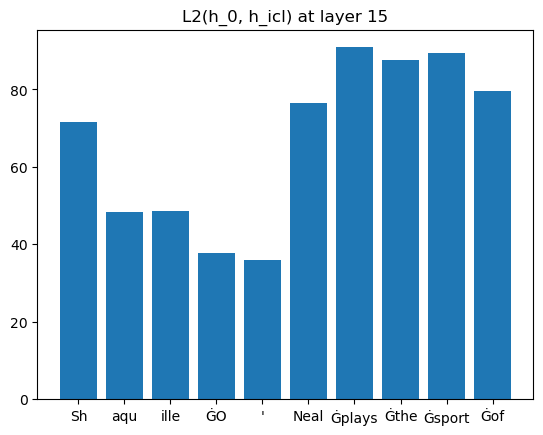

In [24]:
import matplotlib.pyplot as plt

# values = training_utils.cosine_similarity_float16(orig, icl).tolist()[1:]
values = orig.sub(icl).norm(dim=-1).tolist()[1:]

labels = tokenizer.convert_ids_to_tokens(inputs_orig.input_ids[0, 1:].tolist())

print(values, labels)

plt.title("L2(h_0, h_icl) at layer 15")
plt.bar(labels, values)

In [25]:
print(tokenizer.convert_ids_to_tokens(inputs_icl.input_ids[0, i + 1:].tolist()))
print(tokenizer.convert_ids_to_tokens(inputs_orig.input_ids[0].tolist()))

['Sh', 'aqu', 'ille', 'ĠO', "'", 'Neal', 'Ġplays', 'Ġthe', 'Ġsport', 'Ġof']
['<|endoftext|>', 'Sh', 'aqu', 'ille', 'ĠO', "'", 'Neal', 'Ġplays', 'Ġthe', 'Ġsport', 'Ġof']


In [26]:
orig.norm(dim=-1)

tensor([4868.0000,  127.1875,  117.2500,  107.5000,  105.3125,   97.8750,
         114.0625,  108.7500,   96.3750,  116.4375,  109.7500],
       device='cuda:0', dtype=torch.float16)

In [27]:
icl.norm(dim=-1)

tensor([ 97.6250, 104.0625, 116.5625, 108.5625, 107.2500, 102.0000, 112.8750,
        117.3125, 111.5000, 122.5625, 116.5000], device='cuda:0',
       dtype=torch.float16)

In [31]:
orig[1].shape

torch.Size([4096])

In [35]:
sim = torch.nn.CosineSimilarity(dim = 0)

In [36]:
sim(orig[1], orig[-1])

tensor(0.4475, device='cuda:0', dtype=torch.float16)

In [37]:
sim(icl[1], icl[-1])

tensor(0.4878, device='cuda:0', dtype=torch.float16)